# Defining `Function`s on `SubDomain`s

In many contexts, fields are required over only a subset of the computational `Grid`. In Devito, such fields can be implemented via the `Function`s on `SubDomain`s API, allocating arrays only over the required region of the `Grid`, thereby reducing memory consumption. This functionality is seamlessly compatible with MPI, as with any other Devito object, and these arrays are aligned with the domain decomposition under the hood.

We will begin with some necessary imports.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

from IPython.display import HTML

from devito import SubDomain, Grid, Function, Eq, Operator, \
    SparseFunction, ConditionalDimension, TimeFunction, solve, \
    TensorTimeFunction, VectorTimeFunction, diag, grad, div
from examples.seismic import TimeAxis, RickerSource, Model, Receiver

## Basic usage

As usual, we define a subdomain template by subclassing `SubDomain` and overriding the `define` method. The `'middle'` subdomain we have defined in this case excludes two points from each side of the domain in each dimension.

In [2]:
class Middle(SubDomain):
    name = 'middle'

    def define(self, dimensions):
        return {d: ('middle', 2, 2) for d in dimensions}

We then create a `Grid`, followed by an instance of `Middle`. We can then use this subdomain as the computational grid when defining a `Function`. For comparison, we also create a `Function` defined on a `Grid`.

In [3]:
grid0 = Grid(shape=(11, 11), extent=(10., 10.))

middle = Middle(grid=grid0)

f = Function(name='f', grid=middle)  # Define Function on SubDomain
g = Function(name='g', grid=grid0)

Inspecting the `shape` of `f`, it is apparent that it is smaller than the `Grid` on which `middle` is defined. Instead, its shape is that of `middle`.

In [4]:
f.shape

(7, 7)

Furthermore, `f` has the dimensions of the `SubDomain` rather than the `Grid`.

In [5]:
f.dimensions

(ix, iy)

By contrast, when inspecting `g`, we observe that its shape and dimensions match those of the `Grid`.

In [6]:
g.shape

(11, 11)

In [7]:
g.dimensions

(x, y)

To contrast the behaviour of a `Function` defined on a `SubDomain` to one defined on a `Grid`, we implement a trivial `Operator`, setting both `f` and `g` equal to one within the `SubDomain` `middle`.

In [8]:
#NBVAL_IGNORE_OUTPUT
eq_f = Eq(f, 1)
eq_g = Eq(g, 1, subdomain=middle)

Operator([eq_f, eq_g])()

NUMA domain count autodetection failed


Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000196, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Note that if there is only one `SubDomain` on which `Function`s are defined present in the `Eq` expressions, Devito will automatically infer the `subdomain` kwarg if none is supplied. If multiple `SubDomain`s are used to define `Function`s, but no `subdomain` is specified in `Eq`, then an error will be thrown. Inspecting `eq_f`, we see that the `SubDomain` is inferred:

In [9]:
eq_f.subdomain

Middle[middle(ix, iy)]

Examining `f.data`, we see that it has been entirely set to one by the `Operator`. By contrast, `g.data` is only set to one in the central region.

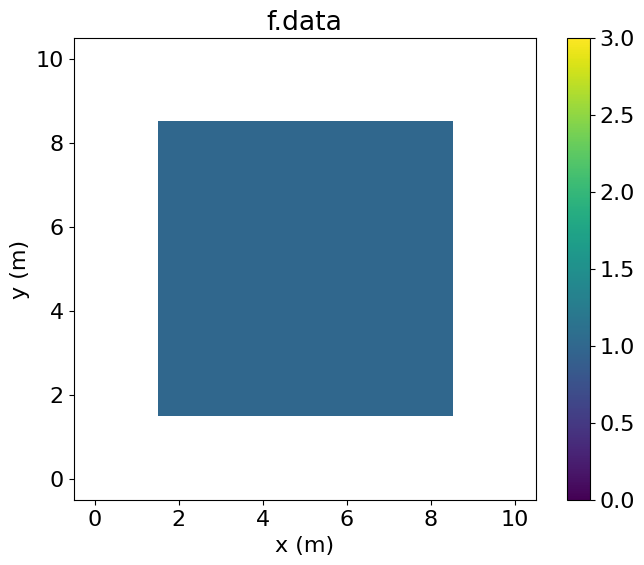

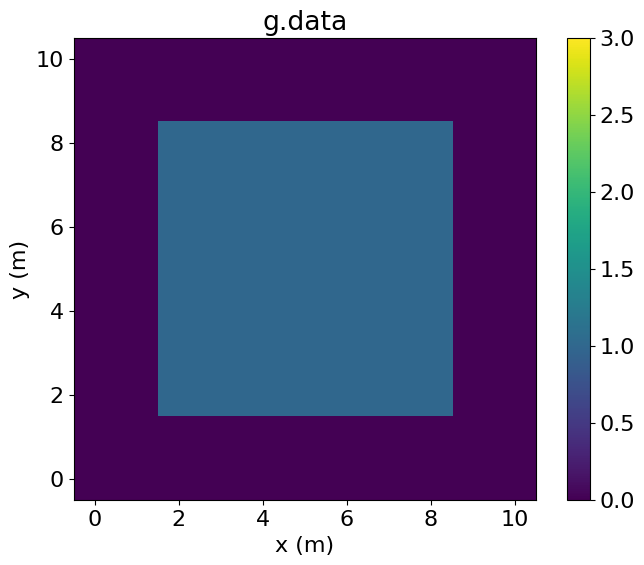

In [10]:
#NBVAL_IGNORE_OUTPUT
plt.imshow(f.data.T, vmin=0, vmax=3, origin='lower', extent=(1.5, 8.5, 1.5, 8.5))
plt.colorbar()
plt.title("f.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim(-0.5, 10.5)
plt.ylim(-0.5, 10.5)
plt.show()

plt.imshow(g.data.T, vmin=0, vmax=3, origin='lower', extent=(-0.5, 10.5, -0.5, 10.5))
plt.colorbar()
plt.title("g.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

When operating on a `Function` defined on a `SubDomain`, Devito keeps track of the alignment of the fields relative to the base `Grid`. As such, we can perform operations combining `Function`s defined on `SubDomain`s with those defined on the `Grid`. For example, we can add `f` to `g` as follows:

In [11]:
#NBVAL_IGNORE_OUTPUT
eq_fg = Eq(g, g + f)
Operator(eq_fg)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000103, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Plotting `g.data`, we see that the central region, corresponding to `middle`, has been incremented by the value of `f`.

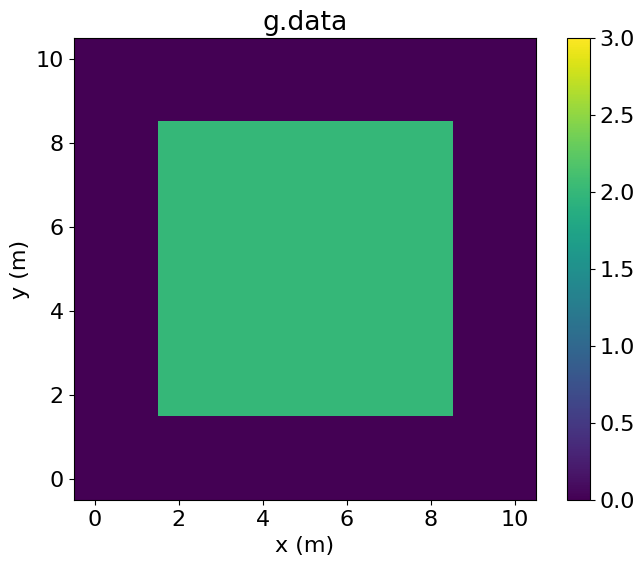

In [12]:
#NBVAL_IGNORE_OUTPUT
plt.imshow(g.data.T, vmin=0, vmax=3, origin='lower', extent=(-0.5, 10.5, -0.5, 10.5))
plt.colorbar()
plt.title("g.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

Note that we need not only iterate over the `SubDomain` on which our `Function` is defined. One can also iterate over any subset of this `SubDomain`. In this case, we define a new `Left` domain, alongside `Intersection`, which is the intersection of `Left` and `Middle`. We then define another `Function` `h` on `left`.

In [13]:
class Left(SubDomain):
    name = 'left'

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', 6), y: y}


class Intersection(SubDomain):
    # Intersection of Left and Middle
    name = 'intersection'

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 2, 5), y: ('middle', 2, 2)}


# Create the SubDomain instances
left = Left(grid=grid0)
intersection = Intersection(grid=grid0)

h = Function(name='h', grid=left)
h.data[:] = 1

Printing `h.shape`, we see that its size is also smaller than that of the `Grid`.

In [14]:
h.shape

(6, 11)

We can then define equations which act over the intersection of `Middle` and `Left`. These equations can operate on any of the `Function`s defined thus far.

In [15]:
#NBVAL_IGNORE_OUTPUT
# Equations operating on Functions defined on SubDomains must be applied over
# the SubDomain, or a SubDomain representing some subset thereof.

# Add h (defined on Left) to g (defined on Grid) over Intersection, and store result in g
eq_gh = Eq(g, g + h, subdomain=intersection)
# Add h (defined on Left) to f (defined on Middle) over Intersection, and store result in f
eq_fh = Eq(f, f + h, subdomain=intersection)

Operator([eq_gh, eq_fh])()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000108, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Plotting both `g` and `f`, we observe that both have been incremented by one (the value stored in`h`) over the intersection.

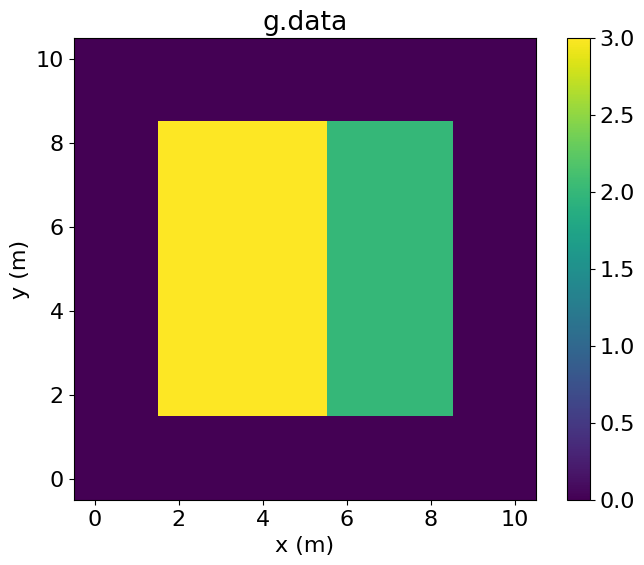

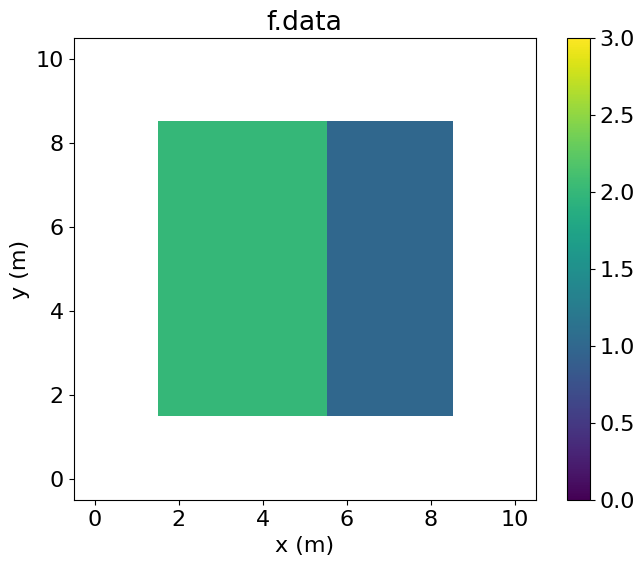

In [16]:
#NBVAL_IGNORE_OUTPUT
plt.imshow(g.data.T, vmin=0, vmax=3, origin='lower', extent=(-0.5, 10.5, -0.5, 10.5))
plt.colorbar()
plt.title("g.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

plt.imshow(f.data.T, vmin=0, vmax=3, origin='lower', extent=(1.5, 8.5, 1.5, 8.5))
plt.colorbar()
plt.title("f.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim(-0.5, 10.5)
plt.ylim(-0.5, 10.5)
plt.show()

Finally, we can also take values from a `Function` defined on the `Grid`, operate on them, and store them in a `Function` defined on a `SubDomain`.

In [17]:
#NBVAL_IGNORE_OUTPUT
eq_gf = Eq(f, g)
Operator(eq_gf)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=6.7e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Note that `f` now contains the same values as the central region of `g`.

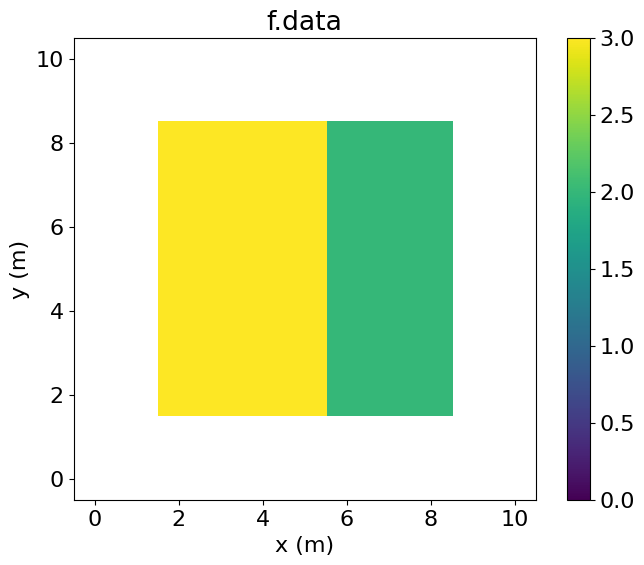

In [18]:
#NBVAL_IGNORE_OUTPUT
plt.imshow(f.data.T, vmin=0, vmax=3, origin='lower', extent=(1.5, 8.5, 1.5, 8.5))
plt.colorbar()
plt.title("f.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim(-0.5, 10.5)
plt.ylim(-0.5, 10.5)
plt.show()

## Sparse operations

Similarly, one can perform sparse operations such as injection into or interpolation off of `Function`s defined on `SubDomain`s. This is performed as per the usual interface. Note however that the operation will be windowed to the `SubDomain`, not the `Grid`, even if it involves the interpolation of an expression featuring both `Function`s defined on a `SubDomain` and those defined on a `Grid`. This is because such an operation would be undefined outside a `SubDomain`.

We begin by constructing a `SparseFunction`.

In [19]:
src_rec = SparseFunction(name='srcrec', grid=grid0, npoint=1)
src_rec.coordinates.data[:] = np.array([[3., 3.]])

A simple interpolation operator is constructed as follows:

In [20]:
#NBVAL_IGNORE_OUTPUT
rec = src_rec.interpolate(expr=f)
Operator(rec)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=9.999999999999999e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Printing `srcrec.data`, it is apparent that it now contains the value interpolated off of `f`.

In [21]:
src_rec.data

Data([3.], dtype=float32)

As aforementioned, one can also interpolate an expression featuring `Function`s defined on both the `Grid` and a `SubDomain`. This can be straightforwardly achieved as follows:

In [22]:
#NBVAL_IGNORE_OUTPUT
rec = src_rec.interpolate(expr=f+g)
Operator(rec)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=7e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Note that since one of our previous operators set `f` equal to `g` over `Middle`, `srcrec.data` is now equal to 6.

In [23]:
src_rec.data

Data([6.], dtype=float32)

We can also inject into a `Function` defined on a `SubDomain`.

In [24]:
#NBVAL_IGNORE_OUTPUT
src = src_rec.inject(field=h, expr=1)
Operator(src)()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=8.599999999999999e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Plotting `h.data`, we see that a value of 1 has been injected. It is also apparent that this injection is aligned with the global grid.

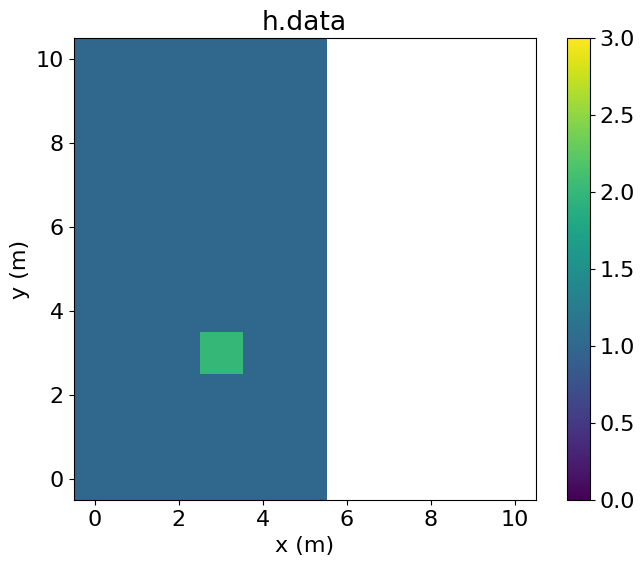

In [25]:
#NBVAL_IGNORE_OUTPUT
plt.imshow(h.data.T, vmin=0, vmax=3, origin='lower', extent=(-0.5, 5.5, -0.5, 10.5))
plt.colorbar()
plt.title("h.data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim(-0.5, 10.5)
plt.ylim(-0.5, 10.5)
plt.show()

## Snapshotting on a subset of a domain

We will now consider a practical application of this functionality. In many applications, it is necessary to capture snapshots of a simulation as it progresses. However, such snapshots may not be needed over the entirety of the domain. We can use a `Function` defined on the subset of the domain that we aim to capture to minimize the size of the arrays allocated.

In this case, we will consider the snapshotting of a seismic wavefield. In imaging workflows, there is no need to calculate an imaging condition in the water column, and thus no need to store snapshots of this portion of the domain.

We begin by setting up the grid parameters and velocity model.

In [26]:
origin = (0., 0.)
shape = (201, 201)
spacing = (5., 5.)
extent = tuple((sh-1)*sp for sh, sp in zip(shape, spacing))

# Layered model
vp = np.full(shape, 1.5)
for i in range(6):
    vp[:, 50+i*25:] += 0.3

We can then construct a `Model`. To highlight the use of `Function`s on `SubDomain`s, we plot the padded velocity model, overlaying the interior domain (i.e. the core computational domain, excluding boundary layers) and the area of interest for snapshotting (excluding the water layer at the top).

Operator `initdamp` ran in 0.01 s


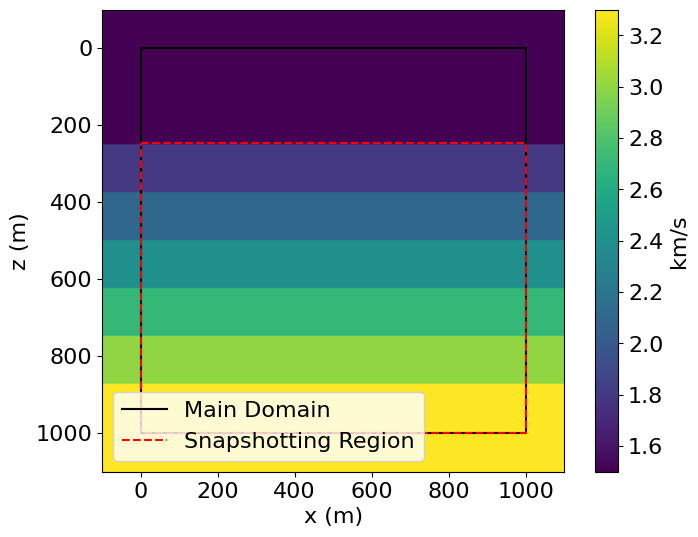

In [27]:
#NBVAL_IGNORE_OUTPUT
model = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=20, bcs="damp")

# Plot velocity model
plt.imshow(model.vp.data.T, extent=(-100, 1100., 1100., -100.))
plt.plot((0, 1000, 1000, 0, 0), (0, 0, 1000, 1000, 0), 'k', label="Main Domain")
plt.plot((0, 1000, 1000, 0, 0), (245, 245, 1000, 1000, 245), 'r--', label="Snapshotting Region")
plt.legend(loc='lower left')
plt.colorbar(label="km/s")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.show()

We then set up a `SubDomain` corresponding to this region.

In [28]:
class SnapshotDomain(SubDomain):
    name = 'snapshot'

    def define(self, dimensions):
        x, y = dimensions
        # Exclude damping layers and water column
        return {x: ('middle', 20, 20), y: ('middle', 70, 20)}


snapshotdomain = SnapshotDomain(grid=model.grid)

A trivial `Operator` can be used to check that the specified `SubDomain` is aligned as intended.

Operator `Kernel` ran in 0.01 s


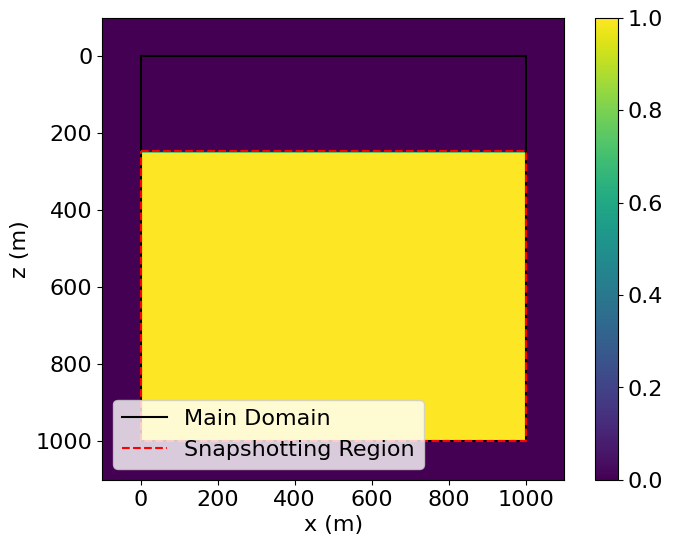

In [29]:
#NBVAL_IGNORE_OUTPUT
# Make a Function and set it equal to one to check the alignment of subdomain
test_func = Function(name='testfunc', grid=model.grid)
Operator(Eq(test_func, 1, subdomain=snapshotdomain))()

# Plotting the resultant field, we see that the incremented region aligns with our
# desired snapshotting region.
plt.imshow(test_func.data.T, extent=(-100, 1100., 1100., -100.))
plt.plot((0, 1000, 1000, 0, 0), (0, 0, 1000, 1000, 0), 'k', label="Main Domain")
plt.plot((0, 1000, 1000, 0, 0), (245, 245, 1000, 1000, 245), 'r--', label="Snapshotting Region")
plt.legend(loc='lower left')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.show()

Now we set up a source.

In [30]:
# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = 500.  # Simulation lasts tn milliseconds
dt = 0.8*model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 0.040  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)

src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

Snapshotting is specified as usual. The only difference is that `grid=snapshotdomain` is passed when instantiating the snapshot `TimeFunction`. For comparison, we also instantiate `usavegrid` in the conventional manner.

In [31]:
nsnaps = 30
factor = int(np.ceil(nt/nsnaps))

time_subsampled = ConditionalDimension('t_sub', parent=model.grid.time_dim, factor=factor)

u_save = TimeFunction(name='usave', grid=snapshotdomain, time_order=0, space_order=2,
                      save=nsnaps, time_dim=time_subsampled)

# "Normal" snapshotting for comparison
u_save_grid = TimeFunction(name='usavegrid', grid=model.grid, time_order=0, space_order=2,
                           save=nsnaps, time_dim=time_subsampled)

Comparing the size of `usave`, allocated on `snapshotdomain`, to `usavegrid`, allocated on `model.grid`, we see that the former has a substantially smaller underlying array than the latter. This yields notable memory savings.

In [32]:
memreduction = round(float(100*(u_save_grid.size - u_save.size)/u_save_grid.size), 2)

print(f"Using `Function`s on `SubDomain`s for this snapshot reduces memory requirements by {memreduction}%")

Using `Function`s on `SubDomain`s for this snapshot reduces memory requirements by 47.06%


We will solve the 2nd-order acoustic wave equation in this case. Note that both "normal" and subdomain snapshots are saved for comparison and plotting. In practice, one would only save the subdomain snapshots to minimise memory consumption.

In [33]:
#NBVAL_IGNORE_OUTPUT
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8)

pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src)

# Save both "normal" and subdomain snapshots for comparison
op = Operator([stencil] + [Eq(u_save, u, subdomain=snapshotdomain), Eq(u_save_grid, u)] + src_term)
op.apply(t_M=nt-2, dt=dt)

Operator `Kernel` ran in 0.09 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0491209999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.001683, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.002006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.037044, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

We then visualise this process with an animation.

In [34]:
#NBVAL_SKIP
def animate_wavefield(f, fg, v, interval=100):
    """
    Create an animation of the wavefield.

    Parameters:
      f        : Snapshots on SubDomain
      fg       : Snapshots on Grid
      v        : Velocity model
      interval : Delay between frames in milliseconds (default: 100)
    """
    # Determine color limits based on full dataset (so they remain constant throughout)
    clip = 0.5
    vmax = clip * np.amax(np.abs(f.data))
    vmin = -vmax

    # Create the figure and axis
    fig, ax = plt.subplots()

    # Draw static elements
    # Velocity model (constant background)
    ax.imshow(v.data.T, cmap="Greys", extent=(-100, 1100, 1100, -100),
              alpha=0.4, zorder=3)
    # Snapshot region (red dashed line)
    ax.plot((0, 1000, 1000, 0, 0), (245, 245, 1000, 1000, 245),
            'r--', label="Snapshotting Region", zorder=4)

    # Draw time-dependent images
    # Initialize with the first frame (frame index 0)
    im_fg = ax.imshow(fg.data[0].T, vmin=vmin, vmax=vmax, cmap="Greys",
                      extent=(-100, 1100, 1100, -100), zorder=1)
    im_f  = ax.imshow(f.data[0].T, vmin=vmin, vmax=vmax, cmap='seismic',
                      extent=(0, 1000, 1000, 245), zorder=2)

    # Set axis limits
    ax.set_xlim(-100, 1100)
    ax.set_ylim(1100, -100)

    # Set axis labels
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")

    def update(frame):
        """Update the images for frame 'frame'."""
        im_fg.set_data(fg.data[frame].T)
        im_f.set_data(f.data[frame].T)
        return im_fg, im_f

    # Determine the total number of frames from the first dimension of f.data
    n_frames = f.data.shape[0]

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=interval, blit=True)
    plt.close()

    return ani

ani = animate_wavefield(u_save, u_save_grid, model.vp)

HTML(ani.to_html5_video())

In [35]:
assert np.isclose(np.linalg.norm(u_save.data), 54.026115, atol=0, rtol=1e-4)
assert np.isclose(np.linalg.norm(u_save_grid.data), 77.89853, atol=0, rtol=1e-4)

## Acoustic-elastic coupling

Another application of the `Function`s on `SubDomain`s functionality is for coupled physics problems in which certain fields are only required over a subset of the domain. By minimising the size of the allocated arrays, the memory required to run such complex models can be substantially reduced.

One such application is for efficiently handling propagation of seismic waves through both fluid and solid media. In the former, wave propagation is purely acoustic, whilst it is elastic in the latter. However, the elastic wave equation is substantially more expensive than its acoustic counterpart and features a greatly increased number of fields. Leveraging `Function`s defined on only a subset of the grid, such computations can be made substantially more memory-efficient.

In this particular case, we will have an upper acoustic domain and a lower elastic domain, overlapping in the center to enable coupling of the two simulations. The transition point will lie above the seafloor to simplify the coupling.

The two domains will be laid out as follows, with the overlap representing the transition zone.

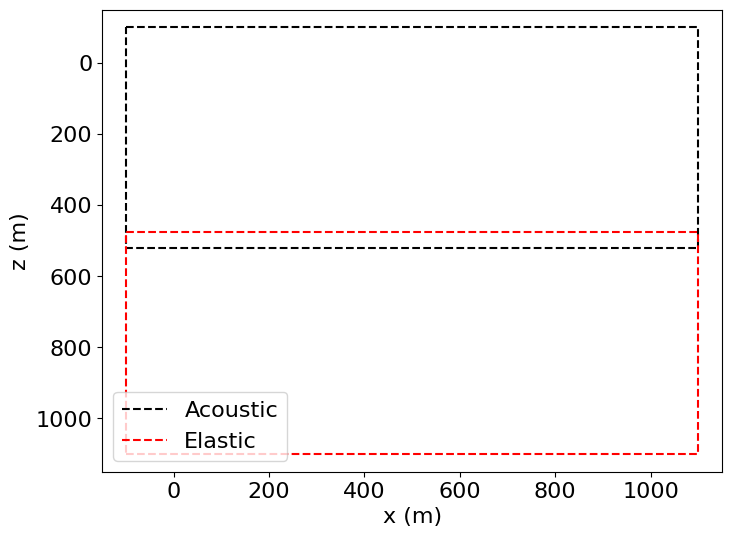

In [36]:
#NBVAL_IGNORE_OUTPUT
plt.plot((-100., 1100., 1100., -100., -100.),
         (-100., -100., 520., 520., -100.),
         'k--', label='Acoustic')
plt.plot((-100., 1100., 1100., -100., -100.),
         (1100., 1100., 475., 475., 1100.),
         'r--', label='Elastic')

plt.legend(loc='lower left')
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.xlim(-150, 1150)
plt.ylim(1150, -150)

plt.show()

To achieve this setup, we will require a total of six `SubDomain`s. These are as follows:
* Two overlapping `SubDomain`s, one for fields only required for acoustic propagation, and one for fields only required for elastic propagation
* Two non-overlapping `SubDomain`s, one for acoustic propagation, and one for elastic propagation
* Two `SubDomain`s to act as 'halos' for coupling the acoustic and elastic models in the upper and lower halves of the transition zone.

In [37]:
so = 8  # Space order
grid1 = Grid(shape=(241, 241), extent=(1200., 1200.), origin=(-100., -100.))


# Acoustic-elastic transition at index 120 (this index is the first elastic one)
class Upper(SubDomain):
    """Upper iteration subdomain"""
    name = 'upper'

    def define(self, dimensions):
        x, y = dimensions
        # Note: uses middle to allow MPI distribution. If MPI is not needed or anticipated
        # then one could use left/right instead
        return {x: x, y: ('middle', 0, 121)}  # 121 + so//2


class Lower(SubDomain):
    """Lower iteration subdomain"""
    name = 'lower'

    def define(self, dimensions):
        x, y = dimensions
        return {x: x, y: ('middle', 120, 0)}  # 120 + so//2


class UpperTransition(SubDomain):
    """Upper transition zone"""
    name = 'uppertransition'

    def define(self, dimensions):
        x, y = dimensions
        return {x: x, y: ('middle', 116, 121)}  # 116 + 121 = 241 - so//2


class LowerTransition(SubDomain):
    """Lower transition zone"""
    name = 'lowertransition'

    def define(self, dimensions):
        x, y = dimensions
        return {x: x, y: ('middle', 120, 117)}  # 120 + 117 = 241 - so//2


class UpperField(SubDomain):
    """Upper subdomain to define fields over"""
    name = 'upperfields'

    def define(self, dimensions):
        x, y = dimensions
        return {x: x, y: ('middle', 0, 117)}  # 121 - so//2


class LowerField(SubDomain):
    """Lower subdomain to define fields over"""
    name = 'lowerfields'

    def define(self, dimensions):
        x, y = dimensions
        return {x: x, y: ('middle', 116, 0)}  # 120 - so//2


# Iteration domains
upper = Upper(grid=grid1)
lower = Lower(grid=grid1)
uppertransition = UpperTransition(grid=grid1)
lowertransition = LowerTransition(grid=grid1)

# Field domains
upperfield = UpperField(grid=grid1)
lowerfield = LowerField(grid=grid1)

As before, it is often helpful to create a trivial `Operator` to check the alignment and layout of the `SubDomain`s created, particularly when a large number are present. Doing so also illustrates how the transition zone is split into upper and lower regions, acting as halos for the elastic and acoustic models respectively.

Operator `Kernel` ran in 0.01 s


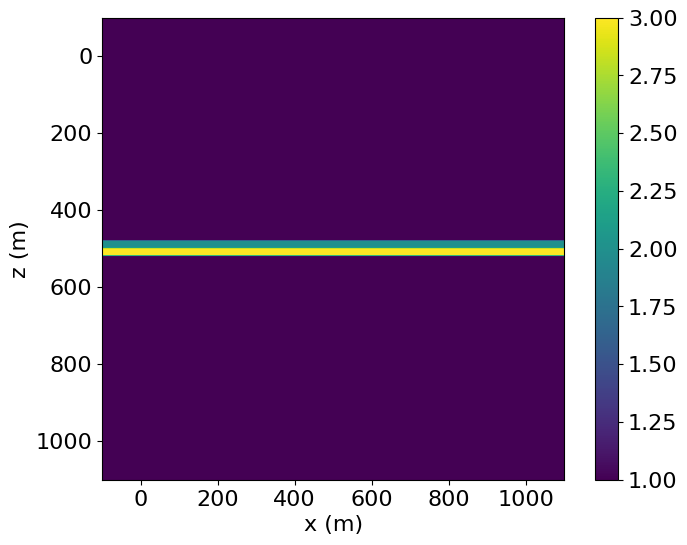

In [38]:
#NBVAL_IGNORE_OUTPUT
# Make a trivial operator to check location of fields
test_func = Function(name='testfunc', grid=grid1)
Operator([Eq(test_func, 1, subdomain=upper),
          Eq(test_func, 1, subdomain=lower),
          Eq(test_func, test_func + 1, subdomain=uppertransition),
          Eq(test_func, test_func + 2, subdomain=lowertransition)])()

plt.imshow(test_func.data.T, extent=(-100., 1100., 1100., -100.))
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.show()

We now define the necessary fields. Only the damping and P-wave velocity fields are required throughout the domain. Thus all remaining fields are defined on either `upperfield` or `lowerfield`, these being the overlapped `SubDomain`s.

In [39]:
# Define the fields
# Fields present everywhere
damp = Function(name='damp', grid=grid1, space_order=so)
cp = Function(name='cp', grid=grid1, space_order=so)

# Fields only present in the upper domain
p = TimeFunction(name='p', grid=upperfield, space_order=so, time_order=2)

# Fields only present in the lower domain
cs = Function(name='cs', grid=lowerfield, space_order=so)
ro = Function(name='ro', grid=lowerfield, space_order=so)
tau = TensorTimeFunction(name='tau', grid=lowerfield, space_order=so)
v = VectorTimeFunction(name='v', grid=lowerfield, space_order=so)

# Initialise parameter fields
ro.data[:] = 1
cp.data[:] = 1.5

# Add an elastic layer below the acoustic-elastic transition
cp.data[:, -100:] = 2.5
cs.data[:, -100:] = 1.5
cp.data[:, -75:] = 3.0
cs.data[:, -75:] = 2.0
cp.data[:, -50:] = 3.5
cs.data[:, -50:] = 2.5
cp.data[:, -25:] = 4.
cs.data[:, -25:] = 3.

# Fill the damping field
maxtaper = 0.5
taper = maxtaper*(0.5 - 0.5*np.cos(np.linspace(0., np.pi, 20)))
damp.data[-20:] += taper[:, np.newaxis]
damp.data[:20] += taper[::-1, np.newaxis]
damp.data[:, -20:] += taper[:]
damp.data[:, :20] += taper[::-1]

Source terms are defined as per usual.

In [40]:
# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = 400.  # Simulation lasts tn milliseconds
dt = float(0.1*np.amin(grid1.spacing)/np.amax(cp.data))  # Time step from grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 0.030  # Source peak frequency is 30Hz (0.030 kHz)
src = RickerSource(name='src', grid=grid1, f0=f0, time_range=time_range)

src.coordinates.data[0, :] = 500.
src.coordinates.data[0, -1] = 350.  # Depth is 350m

Receivers will be placed on the seafloor. Note that this is below the transition, in the elastic zone.

In [41]:
rec = Receiver(name='rec', grid=grid1, npoint=101, time_range=time_range)

rec.coordinates.data[:, 0] = np.linspace(0., 1000., 101)
rec.coordinates.data[:, 1] = 600.

Define some material parameters.

In [42]:
b = 1/ro
mu = cs**2*ro
lam = cp**2*ro - 2*mu

Update and coupling equations are specified. Note that it is important to specify a `SubDomain` when an expression contains `Function`s defined on `SubDomain`s.

In [43]:
# Acoustic update
pde_p = p.dt2 - cp**2*p.laplace + damp*p.dt
eq_p = Eq(p.forward, solve(pde_p, p.forward), subdomain=upper)

# Elastic update
pde_v = v.dt - b*div(tau) + damp*v.forward
pde_tau = tau.dt - lam*diag(div(v.forward)) - mu*(grad(v.forward) + grad(v.forward).transpose(inner=False)) + damp*tau.forward

eq_v = Eq(v.forward, solve(pde_v, v.forward), subdomain=lowerfield)
eq_t = Eq(tau.forward, solve(pde_tau, tau.forward), subdomain=lower)

# Coupling: p -> txx, tyy
eq_txx_tr = Eq(tau[0, 0].forward, p.forward, subdomain=uppertransition)
eq_tyy_tr = Eq(tau[1, 1].forward, p.forward, subdomain=uppertransition)
# Coupling: txx, tyy -> p
eq_p_tr = Eq(p.forward, (tau[0, 0].forward + tau[1, 1].forward)/2, subdomain=lowertransition)

Source and receiver terms are defined.

In [44]:
src_term = src.inject(field=p.forward, expr=src)
rec_term = rec.interpolate(expr=tau[0, 0].forward+tau[1, 1].forward)

Now build and run the `Operator`.

In [45]:
#NBVAL_IGNORE_OUTPUT
from devito import switchconfig

# Note: switchconfig(safe_math=True) is only required here to get consistent norms for testing purposes
# This is not required more widely and can be omitted in practical applications
with switchconfig(safe_math=True):
    op1 = Operator([eq_v,
                eq_p, eq_t,
                eq_p_tr, eq_txx_tr, eq_tyy_tr]
               + src_term + rec_term)
    op1(dt=dt)

Operator `Kernel` ran in 0.74 s


Overlaying the wavefields, we see that they are correctly coupled and aligned.

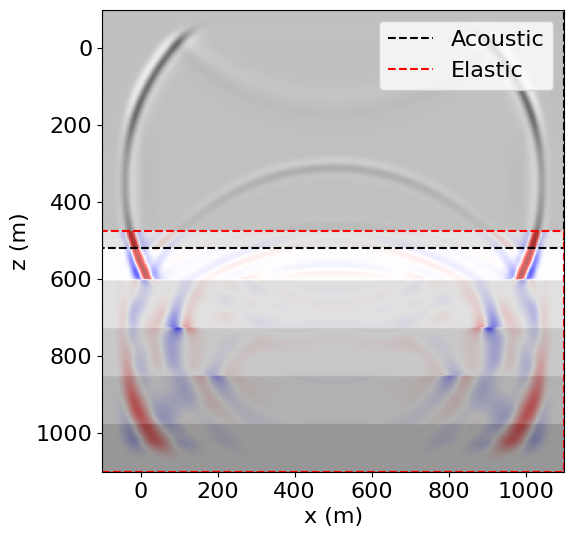

In [46]:
#NBVAL_IGNORE_OUTPUT
vmax_p = np.amax(np.abs(p.data[-1]))
vmax_tau = np.amax(np.abs((tau[0, 0].data[-1] + tau[1, 1].data[-1])/2))
vmax = max(vmax_p, vmax_tau)

plt.imshow(cp.data.T, cmap='Greys', extent=(-100, 1100, 1100, -100))
plt.imshow(p.data[-1].T,
           vmax=vmax, vmin=-vmax, cmap='Greys',
           extent=(-100, 1100, 520, -100),
           alpha=0.6)
plt.imshow((tau[0, 0].data[-1].T + tau[1, 1].data[-1].T)/2,
           vmax=vmax, vmin=-vmax, cmap='seismic',
           extent=(-100, 1100, 1100, 475), alpha=0.6)

plt.plot((-100., 1100., 1100., -100., -100.),
         (-100., -100., 520., 520., -100.),
         'k--', label='Acoustic')
plt.plot((-100., 1100., 1100., -100., -100.),
         (1100., 1100., 475., 475., 1100.),
         'r--', label='Elastic')

plt.legend()


plt.xlim(-100, 1100)
plt.ylim(1100, -100)
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.show()

We can also view the shot record recorded at the ocean-bottom receivers.

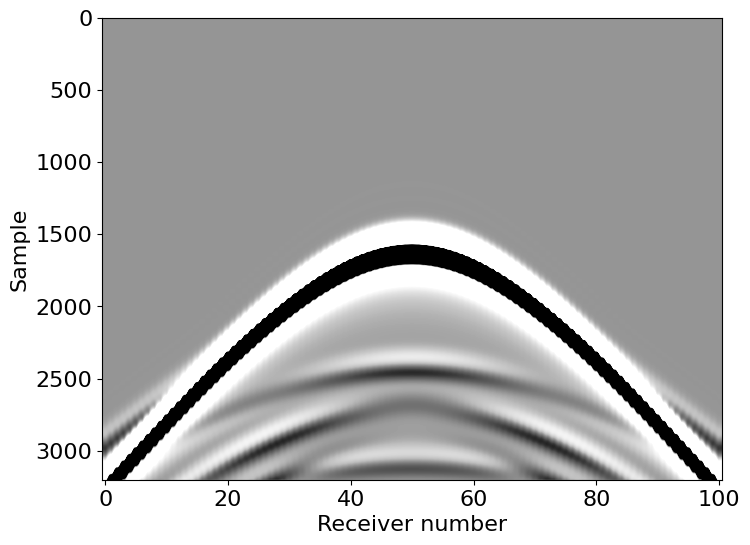

In [47]:
#NBVAL_IGNORE_OUTPUT
vmax = 0.05*np.amax(np.abs(rec.data))
plt.imshow(rec.data, cmap='Greys', aspect='auto', vmax=vmax, vmin=-vmax)
plt.xlabel("Receiver number")
plt.ylabel("Sample")
plt.show()

In [48]:
assert np.isclose(np.linalg.norm(rec.data), 3640.584, atol=0, rtol=1e-4)